# LA to Chicago
This notebook creates a route from the LA/Long beach ports to Chicago using BNSF owned tracks.

In [1]:
import geopandas as gpd
import networkx as nx
from shapely import geometry, ops
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import folium
import time
from requests.auth import AuthBase
import os
from scipy.spatial import distance

In [2]:
URL ="http://score-web-1:8000"
URL1 = URL+"/api-token-auth/"
payload = {'username':'locomotives', 'password':'locomotives'}
URL2 = URL+"/api/line/add/"
URL3 = URL+'/api/railroad/'
URL4 = URL + "/api/line/"
URL5 = URL + "/api/route/add/"
URL6 = URL + "/api/yard/all/"
URL7 = URL + "/api/yard/"
URL8 = URL + "/api/route/detail/"
URL9 = URL + "/api/route/elevations/update/"
URL10 = URL + "/api/yard/add/"

In [3]:
t = requests.post(URL1, data=payload )
token = t.json().get('token')

In [4]:
class TokenAuth(AuthBase):
    """ Implements a custom authentication scheme. """

    def __init__(self, token):
        self.token = token

    def __call__(self, r):
        """ Attach an API token to a custom auth header. """
        r.headers['Authorization'] = "Token " + f'{self.token}'
        return r

In [5]:
r = requests.get(URL3, auth=TokenAuth(token))
railroads=r.json()['results']
railroads

[{'id': 1, 'code': 'BNSF', 'name': 'Burlington Northern and Santa Fe'},
 {'id': 2, 'code': 'CN', 'name': 'Canadian National Railway'},
 {'id': 3, 'code': 'CP', 'name': 'Canadian Pacific Railway'},
 {'id': 4, 'code': 'CSXT', 'name': 'CSX Transportation'},
 {'id': 5, 'code': 'NS', 'name': 'Norfolk Southern Railway'},
 {'id': 6, 'code': 'KCS', 'name': 'Kansas City Southern Railway'},
 {'id': 7, 'code': 'UP', 'name': 'Union Pacific'}]

In [12]:
response = requests.get(URL6, auth=TokenAuth(token))
yards = response.json()['results']
yards

[{'id': 2, 'name': 'Rickenbacker'},
 {'id': 4, 'name': 'Norfolk'},
 {'id': 6, 'name': 'Savannah'},
 {'id': 7, 'name': 'Macon'},
 {'id': 8, 'name': 'Tyrone'},
 {'id': 9, 'name': 'State College'},
 {'id': 5, 'name': 'Suffolk'},
 {'id': 1, 'name': 'Landers Yard'},
 {'id': 14, 'name': 'Maple Heights Intermodal'},
 {'id': 11, 'name': 'Bethlehem Intermodal'},
 {'id': 13, 'name': 'Pitcairn Intermodal'},
 {'id': 12, 'name': 'Rutherford Intermodal'},
 {'id': 15, 'name': '47th Street Intermodal'},
 {'id': 10, 'name': 'Croxton'},
 {'id': 16, 'name': 'Hobart Yard'},
 {'id': 17, 'name': 'Cicero Yard'}]

We need to start by adding "yards" for the LA ports and Chicago. There are many yards in Chicago; we want to select one that is owned by BNSF. The same is true for the LA ports. In LA we use the Hobart yard.

In [11]:
response = requests.get(URL7+'16', auth=TokenAuth(token))
start = response.json()['results']
start

{'id': 16,
 'code': 'HOB',
 'name': 'Hobart Yard',
 'city': 'Los Angeles',
 'state': 'CA',
 'location': 322352,
 'owner': 1}

End the route at teh Cicero Yard in Chicago.

In [13]:
response = requests.get(URL7+'17', auth=TokenAuth(token))
end = response.json()['results']
end

{'id': 17,
 'code': 'CHC',
 'name': 'Cicero Yard',
 'city': 'Chicago',
 'state': 'IL',
 'location': 413437,
 'owner': 1}

The next step is to read in the NARN database.

In [14]:
data = gpd.read_file("North_American_Rail_Network_Lines.geojson")

To simplify things a bit, we will only include BNSF tracks.

In [15]:
bnsf_data = data[data[['rrowner1', 'rrowner2', 'rrowner3', 'trkrghts1', 'trkrghts2', 'trkrghts3', 'trkrghts4', 'trkrghts5', 'trkrghts6', 'trkrghts7', 'trkrghts8', 'trkrghts9']].isin(['BNSF']).any(axis=1)]
#bnsf_data = data

## Determine the shortest route
We use the networkx library to determine the "optimal" route between two nodes on a graph. For this optimization, the graph consists of all nodes and "edges" or lines for which BNSF has owns or has rights. This was determined above.

In [16]:
from_nodes = list(bnsf_data.frfranode)

In [17]:
to_nodes = list(bnsf_data.tofranode)

The nodes in the graph is a union of all of the to and from nodes in the dataset.

In [18]:
all_nodes = list(set(from_nodes) | set(to_nodes))

The next step is to actually create a graph.

In [19]:
G=nx.Graph()

In [20]:
G.add_nodes_from(all_nodes)

We need to add the edges between the nodes and give them a weighting of the distance between the nodes - this will result in the shortest route.

In [22]:
edges = bnsf_data[['frfranode','tofranode', 'miles']].to_records(index=False).tolist()

In [23]:
G.add_weighted_edges_from(edges)

In [24]:
start_node = start['location']
end_node = end['location']

In [25]:
route = nx.astar_path(G, start_node, end_node)

In [26]:
route_data = bnsf_data[(bnsf_data['frfranode'].isin(route) & bnsf_data['tofranode'].isin(route))]

In [27]:
fig = folium.Figure(height=600)
map = folium.Map(location=[40.75, -85.0], zoom_start=10,tile=None)
folium.TileLayer(tiles='http://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png', attr='OpenStreetMap attribution').add_to(map)
folium.TileLayer(tiles='http://{s}.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}', attr='Google Maps').add_to(map)
folium.GeoJson(route_data).add_to(map)
map.add_to(fig)

Let's see how many segments there are along the route.

In [28]:
len(route_data)

1272

In each of these segments are a number of locations. The original database does not do a great job of spacing them out, so we need to take a few steps to correct this for our application. The simplify function reduces the number of locations to specify a curve while maintaining a minum error from the original (1 meter in this case). The conversion to 3857 converts the locations from lat,longs to x,y meters.

In [32]:
route_data = route_data.to_crs(3857)
simple_route = route_data.simplify(1, preserve_topology=False)
len(simple_route.geometry.get_coordinates())

12415

To better support the estimation of gradient (and may also assist in curvature), we should segmentize the data to have a maximum distance between points. This can add significantly to the number of locations again, but does help to regularize the data for the LTD.

In [31]:
simple2_route = simple_route.segmentize(max_segment_length=200)
simple2_route = simple2_route.to_crs(4326)
len(simple2_route.geometry.get_coordinates())

30029

In [33]:
def curve(p1, p2, p3):
    v1=p2-p1
    v2=p3-p2
    v3=p1-p3
    d1=np.linalg.norm(v1)
    d2=np.linalg.norm(v2)
    d3=np.linalg.norm(v3)
    num = 1746.375*2*np.linalg.norm(np.cross(v1,v2))
    d = num/(d1*d2*d3)
    if d<0.01:
        d=0.0
    return d

In [34]:
route_xy = route_data.copy()

In [35]:
route_ll = route_data.to_crs(4326)

In [37]:
API_KEY=

This function sends a number of locations to the Google elevation Rest API at once and gets the results. 

In [38]:
def get_alt(lat, lng):
    st = ""
    # print(lng)
    for i in range(len(lng)):
        st+=str(lat[i])+','+str(lng[i])+'|'
    st=st[:-1]
    url = "https://maps.googleapis.com/maps/api/elevation/json?locations=" + st + "&key=" + API_KEY
    # print(url)
    response = requests.get(url)
    # result = response.json()['results']['elevation']
    # print(response.status)
    # print(response.json()['results'])
    results = response.json()['results']
    res = []
    for rec in results:
        res.append(rec['elevation'])
    # should put in a test for response status before returning an actual value
    return res

We need to explode the multilinestrings that are being used in the NARN database to be linestrings

In [40]:
route_xy.geometry=simple2_route.to_crs(3857)
route_xy2 = route_xy.explode(index_parts=True)

In [41]:
np.array(route_xy2.iloc[0].geometry.coords)

array([[-13097455.86799408,   4012650.35800436],
       [-13097291.4521118 ,   4012642.29902009],
       [-13097127.03622953,   4012634.24003582],
       [-13096962.62034725,   4012626.18105155],
       [-13096798.20446498,   4012618.12206727],
       [-13096661.61533846,   4012622.14476635],
       [-13096526.02830999,   4012639.8439351 ],
       [-13096400.90509102,   4012668.6724036 ],
       [-13096275.33659408,   4012709.43464118],
       [-13096117.53667405,   4012775.86039104],
       [-13095959.73675401,   4012842.2861409 ],
       [-13095801.93683398,   4012908.71189077],
       [-13095644.13691394,   4012975.13764062],
       [-13095486.33699391,   4013041.56339049],
       [-13095377.32237318,   4013080.18994988],
       [-13095253.7577384 ,   4013112.10349257],
       [-13095159.69276868,   4013128.59686426],
       [-13095055.38640581,   4013138.92204536],
       [-13094886.45907853,   4013143.88340462],
       [-13094717.53175125,   4013148.84476387],
       [-13094548.60

In [42]:
route_ll.geometry=simple2_route
route_ll2 = route_ll.explode(index_parts=True)
np.array(route_ll2.iloc[0].geometry.coords)

array([[-117.65644789,   33.87962741],
       [-117.65497092,   33.87956731],
       [-117.65349395,   33.87950721],
       [-117.65201697,   33.8794471 ],
       [-117.65054   ,   33.879387  ],
       [-117.649313  ,   33.879417  ],
       [-117.648095  ,   33.879549  ],
       [-117.646971  ,   33.879764  ],
       [-117.645843  ,   33.880068  ],
       [-117.64442546,   33.88056339],
       [-117.64300792,   33.88105878],
       [-117.64159038,   33.88155417],
       [-117.64017284,   33.88204955],
       [-117.63875529,   33.88254494],
       [-117.637776  ,   33.882833  ],
       [-117.636666  ,   33.883071  ],
       [-117.635821  ,   33.883194  ],
       [-117.634884  ,   33.883271  ],
       [-117.6333665 ,   33.883308  ],
       [-117.631849  ,   33.883345  ],
       [-117.6303315 ,   33.883382  ],
       [-117.628814  ,   33.883419  ],
       [-117.627939  ,   33.883487  ],
       [-117.627023  ,   33.883596  ],
       [-117.62541695,   33.8838656 ],
       [-117.6238109 ,   

This routine creates a line segment for the database that mirrors line segments in the NARN database

In [43]:
def create_row(rowxy, rowll, rights, url, token=None):
    p = np.array(rowxy.geometry.coords)
    pxy = p[:,0:2]
    # we want the interpoint distance between the points - the offset of 1, diagonal of the cdist matrix
    dist = np.diagonal(distance.cdist(pxy, pxy), offset=1)
    lng,lat = rowll.geometry.xy
    ele=get_alt(lat, lng)
    lnglat = np.array(rowll.geometry.coords)
    dele = np.diff(ele)
    gradient = np.divide(dele, dist)
    curvature=[]
    if (len(pxy)>2):
        for i in range(len(pxy)-2):
            curvature.append(curve(pxy[i],pxy[i+1],pxy[i+2]))
        curvature.append(curvature[-1])
    else:
        curvature = [0.0]
    line = {
        "fra_id" : rowxy['fraarcid'],
        "from_node" : rowxy['frfranode'],
        "to_node" : rowxy['tofranode'],
        "length" :dist.sum(),
        "rights" : rights,
        "net": rowxy['net'],
        "xy": pxy.tolist(),
        "elevation": ele,
        "lnglat": lnglat.tolist(),
        "gradient": gradient.tolist(),
        "curvature": curvature,
        "distance":dist.tolist()
    }
    requests.post(url, data=line, auth=TokenAuth(token))
    print(line['fra_id'])
        

Lets test just one for now

In [44]:
create_row(route_xy2.iloc[0], route_ll2.iloc[0], [1], URL2, token)

323951


That works so lets do them all.

In [45]:
for i in range(len(route_xy2)):
    # first test to see if it already exists
    fra_id = route_xy2.iloc[i]['fraarcid']
    response = requests.get(URL4+str(fra_id), auth=TokenAuth(token))
    # if (response.status_code == 204):
    create_row(route_xy2.iloc[i], route_ll2.iloc[i], [1], URL2, token)
    # print(route2_xy2.iloc[i][['fraarcid','frfranode', 'tofranode','net','miles']]) 

323951
323964
324044
324081
324199
324213
324244
324250
324269
324351
324373
324381
324903
324988
325043
325158
325204
325266
325530
325534
325545
325553
325576
325588
325604
325633
325695
325744
325770
325779
325832
325857
325901
325943
326011
326038
326092
326103
326127
326152
326161
326214
326220
326288
326338
326443
326595
326677
326883
326894
327020
327131
327183
327323
327339
327392
327413
327436
327649
327819
327836
327926
327984
327993
328005
328087
328280
328320
328371
328515
328543
328761
328796
328802
328866
328886
329051
329057
329065
329066
329124
329282
329349
329437
329485
329499
329628
329770
329775
329870
329924
329933
329981
329982
329998
330175
330187
330201
330273
330321
330380
330601
330647
330679
330800
330919
330932
330967
330983
331132
331135
331158
331195
331217
331294
331308
331314
331573
331684
331700
331784
331798
331819
331874
331893
331949
331970
331972
331974
332280
332321
332355
332368
332474
332500
332674
332720
332740
332776
332846
332922
332975
333013

The next step to saving a route is to include an  ordered list of nodes used make the route.

In [46]:
len(route_xy2)

1272

In [47]:
response = requests.get(URL6, auth=TokenAuth(token))
response.json()

{'results': [{'id': 2, 'name': 'Rickenbacker'},
  {'id': 4, 'name': 'Norfolk'},
  {'id': 6, 'name': 'Savannah'},
  {'id': 7, 'name': 'Macon'},
  {'id': 8, 'name': 'Tyrone'},
  {'id': 9, 'name': 'State College'},
  {'id': 5, 'name': 'Suffolk'},
  {'id': 1, 'name': 'Landers Yard'},
  {'id': 14, 'name': 'Maple Heights Intermodal'},
  {'id': 11, 'name': 'Bethlehem Intermodal'},
  {'id': 13, 'name': 'Pitcairn Intermodal'},
  {'id': 12, 'name': 'Rutherford Intermodal'},
  {'id': 15, 'name': '47th Street Intermodal'},
  {'id': 10, 'name': 'Croxton'},
  {'id': 16, 'name': 'Hobart Yard'},
  {'id': 17, 'name': 'Cicero Yard'}]}

In [49]:
route_dict = {
    'origin': 16,
    'destination': 17,
    'owner': 1,
    'path': route
}

In [50]:
res = requests.post(URL5, data=route_dict, auth=TokenAuth(token))

In [51]:
res.json()

{'results': 17}

In [52]:
response = requests.get(URL8+'17', auth=TokenAuth(token))

In [53]:
segments=response.json()['results']['segments']

In [54]:
start_elevation = response.json()['results']['start_elevation']

In [55]:
seg_df = pd.DataFrame(segments)

In [56]:
seg_df

,length,degrees,gradient,distance,max_speed,elevation,order
0,188.747478,0.000000,-0.003019,1.887475e+02,60,52.356709,0
1,188.747478,0.000000,-0.003256,3.774950e+02,60,51.742130,1
2,188.747478,0.000000,-0.001822,5.662424e+02,60,51.398258,2
3,188.747478,0.000000,-0.004771,7.549899e+02,60,50.497715,3
4,188.747478,0.000000,-0.004533,9.437374e+02,60,49.642193,4
...,...,...,...,...,...,...,...
26920,106.048509,0.000000,-0.000008,4.366177e+06,60,184.001816,26920
26921,106.048509,0.992513,0.000751,4.366283e+06,60,184.081497,26921
26922,175.378985,0.634186,-0.001983,4.366459e+06,60,183.733780,26922
26923,104.068229,0.000000,0.006942,4.366563e+06,60,184.456268,26923


<Axes: xlabel='distance'>

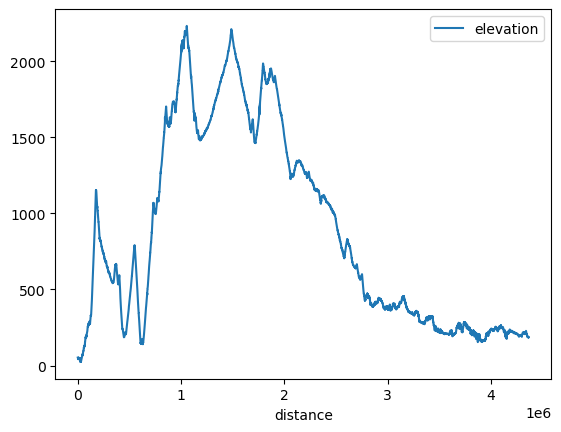

In [57]:
seg_df.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

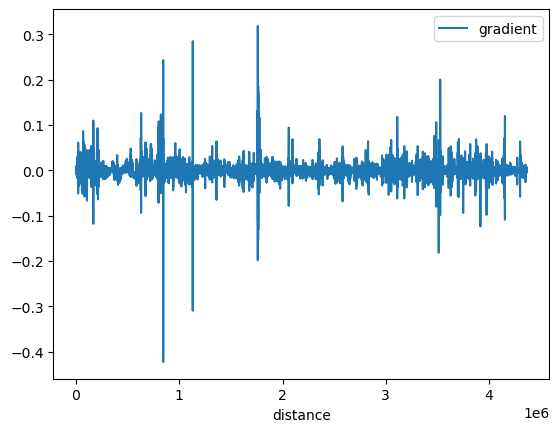

In [58]:
seg_df.plot(x="distance", y="gradient")

There are some pretty obvious excursions from what is typically permitted for gradients here. As a result we will need to go through and spatially filter the data. We need to use a variation of the Savgol filter that can accomodate unequally spaced locations.

In [59]:
def savgol_nonuniform(x, y, window_length, polyorder, deriv=0):
    """
    Savitzky-Golay smoothing 1D filter

    :param x:
    :param y:
    :param window_length: the smoothing sample, e.g. window_length=2 for smoothing over 5 points
    :param polyorder: the degree of the local polynomial fit, e.g. polyorder=2 for a parabolic fit
    :param deriv: The order of the derivative to compute. This must be a nonnegative integer.
            The default is 0, which means to filter the data without differentiating.
    :return:
    """
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)

    n = int((window_length - 1) / 2)

    if x.shape != y.shape:
        raise RuntimeError("x and y arrays are of different shape")
    if x.shape[0] < window_length:
        raise RuntimeError("not enough data to start the smoothing process")
    if 2 * n + 1 <= polyorder + 1:
        raise RuntimeError("need at least deg+1 points to make the polynomial")

    # smooth start and end data
    ysm = np.zeros(y.shape)
    for i in range(n):
        j = y.shape[0] - i - 1
        if deriv == 0:
            ysm[i] = y[i]
            ysm[j] = y[j]
        if deriv == 1:
            ysm[i] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            ysm[j] = (y[j] - y[j - 1]) / (x[j] - x[j - 1])
        if deriv == 2:
            ysm[i] = (((y[i] - y[i - 1]) / (x[i] - x[i - 1])) - ((y[i - 1] - y[i - 2]) / (x[i - 1] - x[i - 2]))) / \
                     (x[i] - x[i - 1])
            ysm[j] = (((y[j] - y[j - 1]) / (x[j] - x[j - 1])) - ((y[j - 1] - y[j - 2]) / (x[j - 1] - x[j - 2]))) / \
                     (x[j] - x[j - 1])
        if deriv >= 3:
            raise NotImplementedError("derivatives >= 3 not implemented")

    m = 2 * n + 1  # the size of the filter window
    o = polyorder + 1  # the smoothing order
    A = np.zeros((m, o))  # A matrix
    t = np.zeros(m)
    # start smoothing
    for i in range(n, x.shape[0] - n):
        for j in range(m):
            t[j] = x[i + j - n] - x[i]
        for j in range(m):
            r = 1.0
            for k in range(o):
                A[j, k] = r
                r *= t[j]
        tA = A.transpose()  # A transposed
        tAA = np.matmul(tA, A)  # make tA.A
        tAA = np.linalg.inv(tAA)  # make (tA.A)-¹ in place
        tAAtA = np.matmul(tAA, tA)  # make (tA.A)-¹.tA

        # compute the polynomial's value at the center of the sample
        ysm[i] = 0.0
        for j in range(m):
            ysm[i] += tAAtA[deriv, j] * y[i + j - n]

    return ysm

In [60]:
x=np.insert(np.array(seg_df['distance']),0,0.0,axis=0)

In [61]:
y=np.insert(np.array(seg_df['elevation']),0, start_elevation, axis=0)

In [62]:
new_elevations = savgol_nonuniform(x,y, 27, 3, 0)
seg_df['new_elevations']=new_elevations[1:]

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

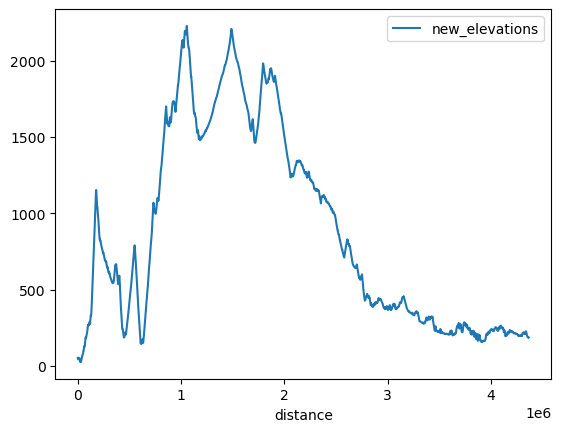

In [63]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["new_elevations"])

<Axes: xlabel='distance'>

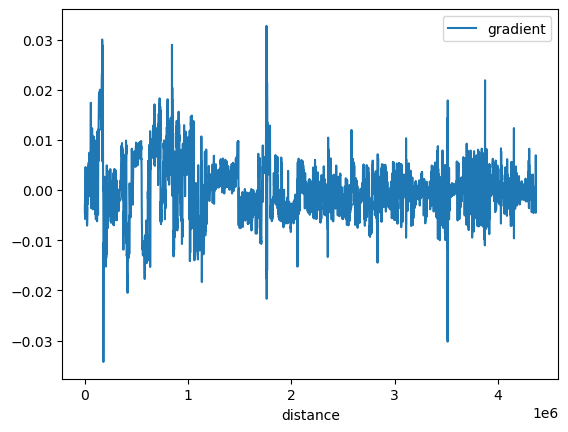

In [76]:
seg_df.plot(x="distance", y="gradient")

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

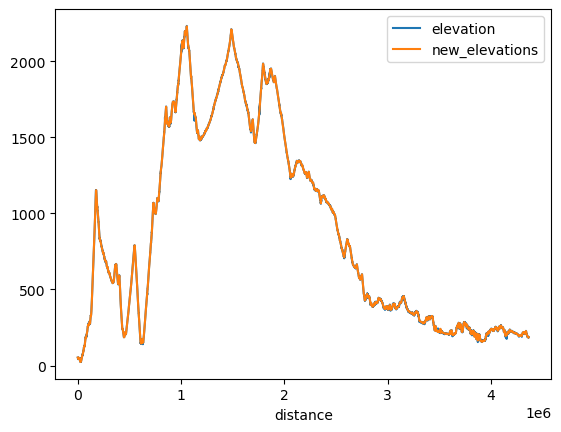

In [64]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["elevation","new_elevations"])

In [65]:
subseg_df = seg_df.iloc[-1100:-900]

<Axes: xlabel='distance'>

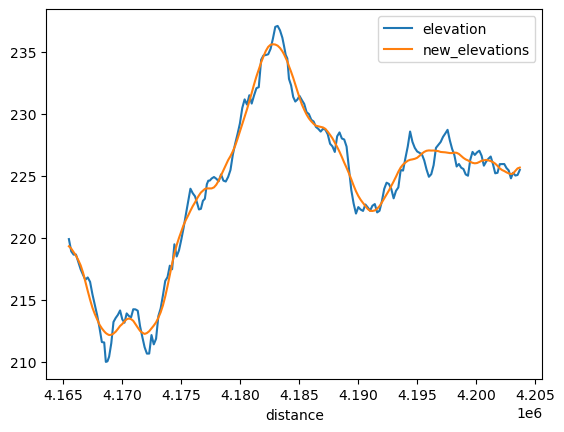

In [66]:
subseg_df.plot(x="distance", y=["elevation","new_elevations"])

<Axes: xlabel='distance'>

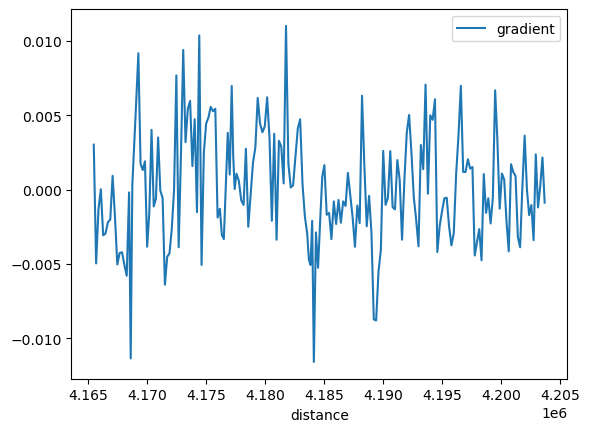

In [67]:
subseg_df.plot(x="distance", y="gradient")

In [68]:
delx = np.diff(x)
len(delx)

26925

In [70]:
dele = np.diff(new_elevations)
len(dele)

26925

In [71]:
temp=delx-np.array(seg_df['length'])
temp.sum()

-2.6520557971920766e-08

In [72]:
grads = np.divide(dele, delx)

In [73]:
grads.max()

0.03274289525550989

In [74]:
seg_df.gradient=grads

<Axes: xlabel='distance'>

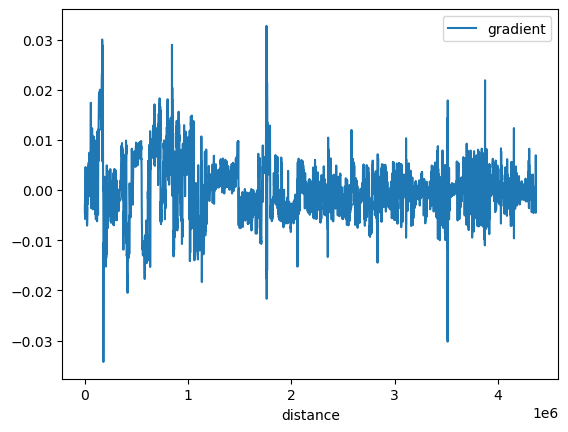

In [75]:
seg_df.plot(x="distance", y="gradient")

This has helped reduce the large gradients seen in the orginal data, but it is still not good enough, as a result we will just cap the largest excursions from the filtered data to be within the standard limits of gradients 0.02.

Let's just go through and cap the gadients to be between -0.02 and 0.02.

In [77]:
seg_df.loc[seg_df.gradient<-0.02, 'gradient']=-0.02

In [78]:
seg_df.loc[seg_df.gradient>0.02, 'gradient']=0.02

<Axes: xlabel='distance'>

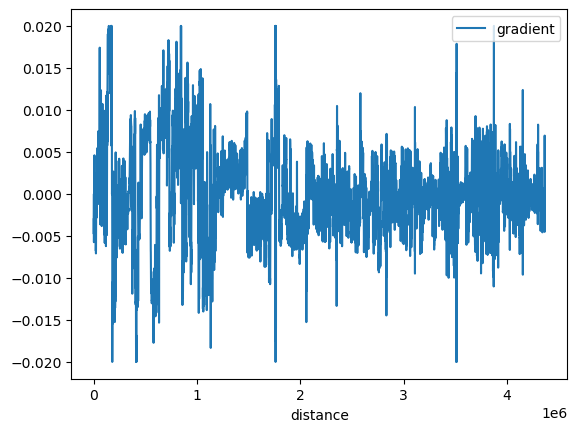

In [79]:
seg_df.plot(x="distance", y="gradient")

In [80]:
data={
    'route':17, 
    'elevations': new_elevations,
    'gradients': list(seg_df['gradient'])
}

In [81]:
URL11 = URL + "/api/something/stupid/"

In [82]:
res = requests.post(URL11, data=data, auth=TokenAuth(token))

In [83]:
res.status_code

200

In [84]:
response = requests.get(URL8+'17', auth=TokenAuth(token))
print(response.status_code)
segments=response.json()['results']['segments']
start_elevation = response.json()['results']['start_elevation']
seg_df2 = pd.DataFrame(segments)

200


<Axes: xlabel='distance'>

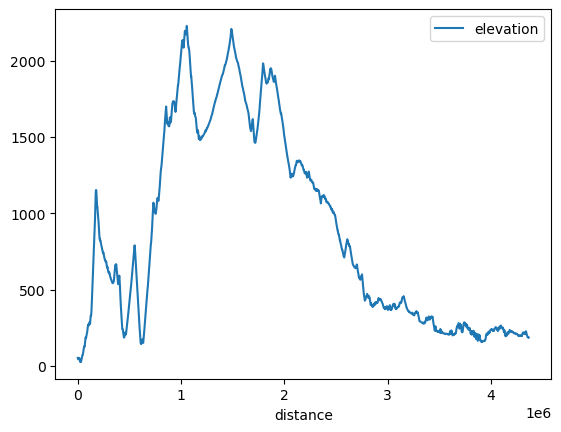

In [85]:
seg_df2.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

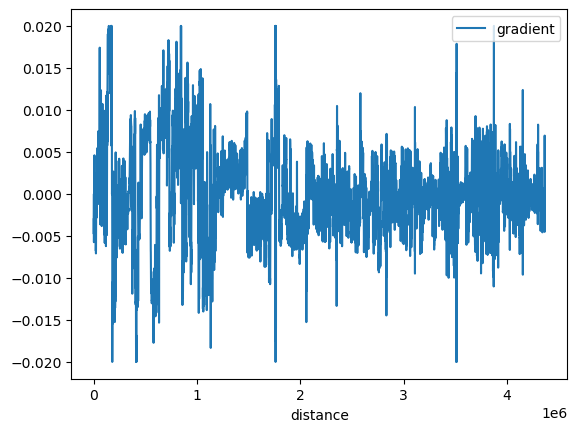

In [86]:
seg_df2.plot(x="distance", y="gradient")

We want to add the reverse route to the database.

In [87]:
 chc_hob_route = {
    'origin': 17,
    'destination': 16,
    'owner': 1,
    'path': list(np.array(route)[::-1])
}

In [88]:
res = requests.post(URL5, data=chc_hob_route, auth=TokenAuth(token))
res.json()

{'results': 18}